**4. Visualising passing locations for Left Center Backs for different categories based on defence lineup and dominant foot of the defenders**

On reviewing the data, we found that the choice of dominant foot for a left center back varies considerably. We intend to find how different footed left center backs contribute to the build-up.

We analysed this pattern for four defender lineups (taking into account right-right-right-left (rrrl) and right-right-left-left (rrll) clusters only as other clusters had very limited datapoints) and three/five defender lineups seperately.

The following tasks are taken into account in this notebook: (These tasks were completed for both four defender and three/five defender formations)

1. Plotted heatmaps for initial and final pass locations for left center backs for all accurate passes and accurate long passes (i.e passes that travel atleast 30m). Also, plotted heatmaps for initial and final pass locations for all inaccurate passes. 

2. Divided the pitch into 8 regions:

     a. Right Flank Attack - x >= 52 and y <= 17
     
     b. Right Flank Defence - x < 52 and y <= 17
     
     c. Right Central Attack - x >= 52 and y > 17 and y <= 34
     
     d. Right Central Defence - x < 52 and y > 17 and y <= 34
     
     e. Left Central Attack - x >= 52 and y > 34 and y <= 51 
     
     f. Left Central Defence - x < 52 and y > 34 and y <= 51
     
     g. Left Flank Attack - x >= 52 and y > 51 and y <= 68
     
     h. Left Flank Defence - x < 52 and y > 51 and y <= 68
     
     
    and calculated the percentage of accurate long balls (i.e. number of accurate long balls in region/total number of acurate long balls) made in these regions.
     
3. Used hypothesis testing to validate if the results found were statistically significant

4. Performed random sampling test


# Imports 

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse
import seaborn as sns
import math
import matplotlib.pylab as pyl
import pickle
import swifter
import warnings
import plotly.express as px
from itertools import chain
import scipy.stats as sps
import itertools
import os
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [88]:
#pd.set_option('max_colwidth', 999)
pd.set_option('display.max_columns', 1000)
pd.set_option("display.max_rows", 3000)
warnings.filterwarnings('ignore')

# Data 

**For reference-**

**RRRL stands for a defence line up with preferred feet of the order (from right back to left back): right footed - right footed - right footed - left footed**

**RRLL stands for a defence line up with preferred feet of the order (from right back to left back): right footed - right footed - left footed - left footed**

In [89]:
rrrl = pd.read_pickle('../data/clusters/clusters_v3/cluster_rrrl.pkl')
rrrl.reset_index(drop=True, inplace=True)
rrrl.head()

,wyId,team,team_defense,RB,R_CB,L_CB,LB,RCB,CB,LCB,RWB,LWB,backline,match,gameweek,teamsData,dateutc,venue,referees,score,footedness,RB_pass,RB_accpass,RB_highpass,RB_acchighpass,RB_accpassloc,RB_inaccpassloc,RB_acchighpassloc,RB_inacchighpassloc,R_CB_pass,R_CB_accpass,R_CB_highpass,R_CB_acchighpass,R_CB_accpassloc,R_CB_inaccpassloc,R_CB_acchighpassloc,R_CB_inacchighpassloc,L_CB_pass,L_CB_accpass,L_CB_highpass,L_CB_acchighpass,L_CB_accpassloc,L_CB_inaccpassloc,L_CB_acchighpassloc,L_CB_inacchighpassloc,LB_pass,LB_accpass,LB_highpass,LB_acchighpass,LB_accpassloc,LB_inaccpassloc,LB_acchighpassloc,LB_inacchighpassloc
0,2500089,Burnley,"[MatthewLowton, KevinLong, JamesTarkowski, Ste...",MatthewLowton,KevinLong,JamesTarkowski,StephenWard,NaN,NaN,NaN,NaN,NaN,4.0,Burnley-Bournemouth,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",2018-05-13 14:00:00,Turf Moor,"[{'refereeId': 385705, 'role': 'referee'}, {'r...",1 - 2,right-right-right-left,38,25,3,2,"[[[33.28, 11.56], [20.8, 23.8]], [[12.48, 9.52...","[[[67.6, 6.8], [76.96, 0.0]], [[28.08, 8.84], ...","[[[38.48, 5.44], [62.4, 10.2]], [[49.92, 14.28...","[[[30.16, 4.76], [93.6, 19.04]]]",45,39,4,2,"[[[20.8, 23.8], [7.28, 31.28]], [[10.4, 10.2],...","[[[37.44, 37.4], [63.44, 48.96]], [[45.76, 33....","[[[53.04, 12.24], [87.36, 60.52]], [[33.28, 36...","[[[31.2, 34.68], [75.92, 47.6]], [[74.88, 0.68...",39,32,11,9,"[[[33.28, 63.92], [61.36, 67.32]], [[35.36, 57...","[[[36.4, 51.68], [69.68, 59.84]], [[7.28, 57.1...","[[[32.24, 61.88], [71.76, 62.56]], [[44.72, 51...","[[[36.4, 51.68], [69.68, 59.84]], [[7.28, 57.1...",47,23,9,1,"[[[72.8, 63.92], [79.04, 65.96]], [[32.24, 57....","[[[43.68, 59.16], [74.88, 65.96]], [[102.96, 2...","[[[24.96, 59.84], [62.4, 61.88]]]","[[[65.52, 65.28], [76.96, 60.52]], [[40.56, 61..."
1,2500097,Leicester,"[DannySimpson, WesMorgan, HarryMaguire, Christ...",DannySimpson,WesMorgan,HarryMaguire,ChristianFuchs,NaN,NaN,NaN,NaN,NaN,4.0,Spurs-Leicester,38,"{'1631': {'scoreET': 0, 'coachId': 209010, 'si...",2018-05-13 14:00:00,Wembley Stadium,"[{'refereeId': 378951, 'role': 'referee'}, {'r...",5 - 4,right-right-right-left,15,7,5,2,"[[[33.28, 6.8], [11.44, 26.52]], [[17.68, 14.9...","[[[23.92, 3.4], [73.84, 34.68]], [[33.28, 1.36...","[[[16.64, 11.56], [38.48, 1.36]], [[15.6, 13.6...","[[[23.92, 3.4], [73.84, 34.68]], [[55.12, 1.36...",13,11,0,0,"[[[27.04, 8.84], [31.2, 10.2]], [[63.44, 59.84...","[[[54.08, 40.8], [78.0, 20.4]], [[12.48, 26.52...",[],[],29,19,6,3,"[[[23.92, 23.12], [31.2, 16.32]], [[34.32, 50....","[[[28.08, 34.68], [47.84, 6.12]], [[68.64, 51....","[[[44.72, 48.28], [45.76, 20.4]], [[36.4, 53.7...","[[[68.64, 51.0], [104.0, 57.12]], [[38.48, 36....",36,26,6,3,"[[[43.68, 63.92], [69.68, 65.96]], [[8.32, 63....","[[[6.24, 44.88], [34.32, 47.6]], [[38.48, 61.2...","[[[37.44, 63.92], [79.04, 31.28]], [[44.72, 62...","[[[6.24, 44.88], [34.32, 47.6]], [[54.08, 61.8..."
2,2500096,Stoke,"[MoritzBauer, RyanShawcross, KurtZouma, ErikPi...",MoritzBauer,RyanShawcross,KurtZouma,ErikPieters,NaN,NaN,NaN,NaN,NaN,4.0,Swansea-Stoke,38,"{'10531': {'scoreET': 0, 'coachId': 32573, 'si...",2018-05-13 14:00:00,Liberty Stadium,"[{'refereeId': 378952, 'role': 'referee'}, {'r...",1 - 2,right-right-right-left,19,16,1,1,"[[[81.12, 11.56], [68.64, 29.92]], [[13.52, 22...","[[[88.4, 10.88], [104.0, 0.0]], [[72.8, 2.72],...","[[[5.2, 14.28], [40.56, 6.8]]]",[],33,27,7,4,"[[[37.44, 21.08], [16.64, 34.68]], [[23.92, 11...","[[[41.6, 20.4], [88.4, 35.36]], [[28.08, 2.72]...","[[[23.92, 11.56], [73.84, 8.16]], [[20.8, 13.6...","[[[41.6, 20.4], [88.4, 35.36]], [[28.08, 2.72]...",32,32,0,0,"[[[32.24, 55.76], [38.48, 51.68]], [[18.72, 54...",[],[],[],48,41,3,2,"[[[35.36, 65.96], [62.4, 67.32]], [[19.76, 59....","[[[2.08, 68.0], [28.08, 68.0]], [[8.32, 67.32]...","[[[16.64, 59.16], [55.12, 54.4]], [[74.88, 60....","[[[30.16, 44.2], [71.76, 49.64]]]"
3,2500093,Watford,"[DarylJanmaat, CraigCathcart, ChristianKabasel...",DarylJanmaat,CraigCathcart,ChristianKabasele,JoseHolebas,NaN,Na

In [90]:
rrll = pd.read_pickle('../data/clusters/clusters_v3/cluster_rrll.pkl')
rrll.reset_index(drop=True, inplace=True)
rrll.head()

,wyId,team,team_defense,RB,R_CB,L_CB,LB,RCB,CB,LCB,RWB,LWB,backline,match,gameweek,teamsData,dateutc,venue,referees,score,footedness,RB_pass,RB_accpass,RB_highpass,RB_acchighpass,RB_accpassloc,RB_inaccpassloc,RB_acchighpassloc,RB_inacchighpassloc,R_CB_pass,R_CB_accpass,R_CB_highpass,R_CB_acchighpass,R_CB_accpassloc,R_CB_inaccpassloc,R_CB_acchighpassloc,R_CB_inacchighpassloc,L_CB_pass,L_CB_accpass,L_CB_highpass,L_CB_acchighpass,L_CB_accpassloc,L_CB_inaccpassloc,L_CB_acchighpassloc,L_CB_inacchighpassloc,LB_pass,LB_accpass,LB_highpass,LB_acchighpass,LB_accpassloc,LB_inaccpassloc,LB_acchighpassloc,LB_inacchighpassloc
0,2500090,Crystal Palace,"[AaronWanBissaka, JamesTomkins, MamadouSakho, ...",AaronWanBissaka,JamesTomkins,MamadouSakho,PatrickvanAanholt,NaN,NaN,NaN,NaN,NaN,4.0,Crystal Palace-West Brom,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",2018-05-13 14:00:00,Selhurst Park,"[{'refereeId': 381851, 'role': 'referee'}, {'r...",2 - 0,right-right-left-left,58,53,1,1,"[[[60.32, 11.56], [70.72, 8.84]], [[55.12, 11....","[[[86.32, 22.44], [87.36, 25.84]], [[98.8, 10....","[[[24.96, 6.8], [45.76, 15.64]]]",[],43,39,3,0,"[[[20.8, 14.96], [31.2, 11.56]], [[30.16, 25.1...","[[[22.88, 25.84], [88.4, 8.16]], [[47.84, 21.0...",[],"[[[22.88, 25.84], [88.4, 8.16]], [[47.84, 21.0...",61,53,5,2,"[[[38.48, 46.24], [40.56, 27.2]], [[31.2, 50.3...","[[[40.56, 58.48], [79.04, 51.0]], [[42.64, 55....","[[[14.56, 61.2], [32.24, 61.2]], [[18.72, 56.4...","[[[40.56, 58.48], [79.04, 51.0]], [[45.76, 57....",49,45,1,0,"[[[35.36, 63.24], [54.08, 57.8]], [[35.36, 65....","[[[89.44, 53.04], [95.68, 44.88]], [[38.48, 55...",[],"[[[38.48, 55.76], [92.56, 29.24]]]"
1,2500095,Man City,"[Danilo, JohnStones, AymericLaporte, FabianDelph]",Danilo,JohnStones,AymericLaporte,FabianDelph,NaN,NaN,NaN,NaN,NaN,4.0,Southampton-Man City,38,"{'1625': {'scoreET': 0, 'coachId': 267136, 'si...",2018-05-13 14:00:00,St. Mary's Stadium,"[{'refereeId': 385911, 'role': 'referee'}, {'r...",0 - 1,right-right-left-left,76,70,2,1,"[[[59.28, 4.08], [68.64, 26.52]], [[58.24, 9.5...","[[[38.48, 10.88], [40.56, 6.8]], [[35.36, 10.2...","[[[65.52, 8.84], [85.28, 4.76]]]","[[[62.4, 30.6], [104.0, 53.72]]]",73,71,6,6,"[[[35.36, 34.0], [82.16, 61.88]], [[30.16, 19....","[[[33.28, 31.96], [38.48, 32.64]], [[8.32, 57....","[[[35.36, 34.0], [82.16, 61.88]], [[7.28, 17.6...",[],77,67,0,0,"[[[39.52, 24.48], [30.16, 19.04]], [[27.04, 52...","[[[29.12, 47.6], [34.32, 44.88]], [[62.4, 48.9...",[],[],0,0,0,0,[],[],[],[]
2,2500086,Crystal Palace,"[JoelWard, JamesTomkins, MamadouSakho, Patrick...",JoelWard,JamesTomkins,MamadouSakho,PatrickvanAanholt,NaN,NaN,NaN,NaN,NaN,4.0,Stoke-Crystal Palace,37,"{'1639': {'scoreET': 0, 'coachId': 8329, 'side...",2018-05-05 11:30:00,Bet365 Stadium,"[{'refereeId': 384888, 'role': 'referee'}, {'r...",1 - 2,right-right-left-left,13,11,2,1,"[[[53.04, 34.0], [75.92, 34.68]], [[58.24, 2.7...","[[[59.28, 2.72], [104.0, 2.72]], [[28.08, 2.72...","[[[78.0, 2.72], [87.36, 46.92]]]","[[[59.28, 2.72], [104.0, 2.72]]]",25,22,1,0,"[[[38.48, 37.4], [37.44, 42.16]], [[31.2, 40.8...","[[[20.8, 40.8], [81.12, 33.32]], [[38.48, 46.2...",[],"[[[20.8, 40.8], [81.12, 33.32]]]",47,40,7,4,"[[[28.08, 42.16], [27.04, 47.6]], [[30.16, 36....","[[[27.04, 36.04], [92.56, 68.0]], [[6.24, 59.8...","[[[48.88, 57.12], [69.68, 46.92]], [[23.92, 42...","[[[27.04, 36.04], [92.56, 68.0]], [[26.0, 43.5...",42,33,3,0,"[[[27.04, 47.6], [8.32, 40.12]], [[63.44, 61.2...","[[[38.48, 51.0], [90.48, 26.52]], [[24.96, 63....",[],"[[[38.48, 51.0], [90.48, 26.52]], [[32.24, 59...."
3,2500072,Stoke,"[KurtZouma, RyanShawcross, BrunoMartinsIndi, E...",KurtZouma,RyanShawcross,BrunoMartinsIndi,ErikPieters,NaN,NaN,NaN,NaN,NaN,4.0,Liverpool-Stoke,36,"{'1639': {'scoreET': 0, 'coachId': 0, 'side': ...",2018-04-28 11:30:00,Anfield,"[{'refereeId': 385911, 'role': 'referee'}, {'r...",0 - 0,right-right-left-left,15,9,6,2,"[[[17.68, 11.56], [34.32, 17.0]], [[17.68, 6.1...","[[[47.84, 6.12], [71.76, 0.0]], [[34.32, 8.16]...

In [91]:
three_five_clusters = ['rrl','rrr','rll','rrrll','rrrrl','rlr','rrrlr','rrlll']
lcb_lf_clusters = ['rrl','rll','rrrll','rrrlr','rrlll']
lcb_rf_clusters = ['rrr','rrrrl','rlr']
path = '../data/clusters/clusters_v3'
lcb_lf_files = [os.path.join(path,f"cluster_{name}.pkl") for name in lcb_lf_clusters]
lcb_rf_files = [os.path.join(path,f"cluster_{name}.pkl") for name in lcb_rf_clusters]
lcb_lf = pd.concat((pd.read_pickle(file) for file in lcb_lf_files), axis = 0, ignore_index = True)
lcb_rf = pd.concat((pd.read_pickle(file) for file in lcb_rf_files), axis = 0, ignore_index = True)

# Functions 

## Plot a Football Pitch

{x:[0,104]; y:[0,68]}

In [92]:
def draw_pitch(line, orientation,view):
    
    orientation = orientation
    view = view
    line = line
    
    if orientation.lower().startswith("h"):
        
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.xlim(49,105)
            plt.ylim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.xlim(-1,105)
            plt.ylim(-1,69)
        ax.axis('off') # this hides the x and y ticks
    
        # side and goal lines #
        ly1 = [0,0,68,68,0]
        lx1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        ly2 = [13.84,13.84,54.16,54.16] 
        lx2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        ly3 = [13.84,13.84,54.16,54.16] 
        lx3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        ly4 = [30.34,30.34,37.66,37.66]
        lx4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        ly5 = [30.34,30.34,37.66,37.66]
        lx5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        ly6 = [24.84,24.84,43.16,43.16]
        lx6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        ly7 = [24.84,24.84,43.16,43.16]
        lx7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        ly8 = [0,68] 
        lx8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        circle3 = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)
        circle4 = plt.Circle((93, 34), 0.2,ls='solid',lw=1.5,color=line, fill=False, alpha=1)
        circle5 = plt.Circle((11, 34), 0.2,ls='solid',lw=1.5,color=line, fill=False, alpha=1)
        circle6 = plt.Circle((52, 34), 0.2,ls='solid',lw=1.5,color=line, fill=False, alpha=1)

        ## Rectangles in boxes
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-', color="None", zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-', color='None', zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 106,70,ls='-',color="None", zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        ax.add_artist(circle4)
        ax.add_artist(circle5)
        ax.add_artist(circle6)
        
    else:
        if view.lower().startswith("h"):
            fig,ax = plt.subplots(figsize=(10.4,6.8))
            plt.ylim(49,105)
            plt.xlim(-1,69)
        else:
            fig,ax = plt.subplots(figsize=(6.8,10.4))
            plt.ylim(-1,105)
            plt.xlim(-1,69)
        ax.axis('off') # this hides the x and y ticks

        # side and goal lines #
        lx1 = [0,0,68,68,0]
        ly1 = [0,104,104,0,0]

        plt.plot(lx1,ly1,color=line,zorder=5)


        # boxes, 6 yard box and goals

            #outer boxes#
        lx2 = [13.84,13.84,54.16,54.16] 
        ly2 = [104,87.5,87.5,104]
        plt.plot(lx2,ly2,color=line,zorder=5)

        lx3 = [13.84,13.84,54.16,54.16] 
        ly3 = [0,16.5,16.5,0]
        plt.plot(lx3,ly3,color=line,zorder=5)

            #goals#
        lx4 = [30.34,30.34,37.66,37.66]
        ly4 = [104,104.2,104.2,104]
        plt.plot(lx4,ly4,color=line,zorder=5)

        lx5 = [30.34,30.34,37.66,37.66]
        ly5 = [0,-0.2,-0.2,0]
        plt.plot(lx5,ly5,color=line,zorder=5)


           #6 yard boxes#
        lx6 = [24.84,24.84,43.16,43.16]
        ly6 = [104,99.5,99.5,104]
        plt.plot(lx6,ly6,color=line,zorder=5)

        lx7 = [24.84,24.84,43.16,43.16]
        ly7 = [0,4.5,4.5,0]
        plt.plot(lx7,ly7,color=line,zorder=5)

        #Halfway line, penalty spots, and kickoff spot
        lx8 = [0,68] 
        ly8 = [52,52]
        plt.plot(lx8,ly8,color=line,zorder=5)


        plt.scatter(34,93,color=line,zorder=5)
        plt.scatter(34,11,color=line,zorder=5)
        plt.scatter(34,52,color=line,zorder=5)

        circle1 = plt.Circle((34,93.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle2 = plt.Circle((34,10.5), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=1,alpha=1)
        circle3 = plt.Circle((34,52), 9.15,ls='solid',lw=1.5,color=line, fill=False, zorder=2,alpha=1)


        ## Rectangles in boxes
        rec1 = plt.Rectangle((20, 87.5), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)
        rec2 = plt.Rectangle((20, 0), 30,16.5,ls='-',color=pitch, zorder=1,alpha=1)

        ## Pitch rectangle
        rec3 = plt.Rectangle((-1, -1), 70,106,ls='-',color=pitch, zorder=1,alpha=1)

        ax.add_artist(rec3)
        ax.add_artist(circle1)
        ax.add_artist(circle2)
        ax.add_artist(rec1)
        ax.add_artist(rec2)
        ax.add_artist(circle3)
        
        
    return fig, ax

(<Figure size 748.8x489.6 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f97cf8ba790>)

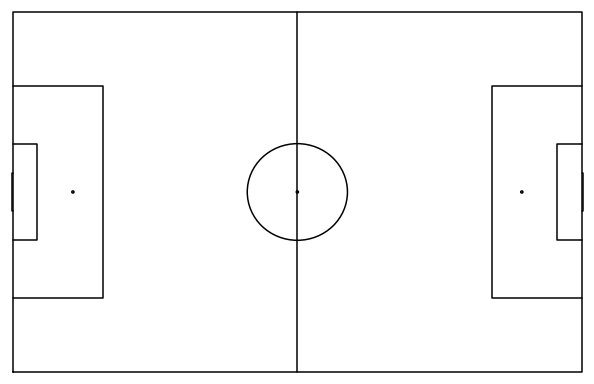

In [93]:
draw_pitch("#000000","h","full")

## Plot Event Data points on the Pitch 

In [94]:
def plot_points(x,y,c):
    draw_pitch("#faf0e6","h","full")
    plt.scatter(x,y,marker='o',color=c,edgecolors="black", zorder=12)
    plt.show()

## Get (x,y) coordinates from DataFrame 

In [95]:
def get_xy(df, col, n, m): #n - no of row entries
    # m = 0: Initial Position
    # m = 1: Final Position
    x=list()
    y=list()
    for i in range(0,n):
        for j in range(0, len(df[col][i])):
            for k in range(0,2):
                x.append(df[col][i][j][k][0])
                y.append(df[col][i][j][k][1])
    x = [x[i] for i in range(0+m, len(x), 2)]
    y = [y[i] for i in range(0+m, len(y), 2)]
    return x, y

## Plot Event Data Heatmap on Pitch 

In [96]:
def heatmap(x, y, title, c):
    fig, ax = draw_pitch("#000000","h","full")
    sns.kdeplot(x, y, cmap = c, shade = True)
    plt.title(title, fontsize = 30)
    plt.xlim(-1,105)
    plt.ylim(-1,69)
    plt.axis('off')
    plt.show()

## Compute and Generate KDE of Pass Distances 

In [97]:
def compute_dist_pdf(df, col):
    dist=list()
    for j in range(0, len(df)):
        d = [np.subtract(i[1], i[0]) for i in df[col][j]]
        d = [list(np.square(i)) for i in d]
        d = [(i[0]+i[1])**(0.5) for i in d]
        dist.append(d)
    sns.set(color_codes=True)
    sns.kdeplot(list(itertools.chain(*dist)), shade=True)
    return dist

## Filter Long Passes 

Long Pass - Pass distance >= 35 meters

In [98]:
def dist_threshold(df, col, n, m):
    x=list()
    y=list()
    x1=list()
    y1=list()
    for i in range(0,n):
        for j in range(0, len(df[col][i])):
            for k in range(0,2):
                x.append(df[col][i][j][k][0])
                y.append(df[col][i][j][k][1])
                
    for i in range(0, len(x), 2):
        dist = ((x[i] - x[i+1])**2 + (y[i] - y[i+1])**2)**(0.5)
        if (dist >= 35):
            x1.append(x[i])
            x1.append(x[i+1])
            y1.append(y[i])
            y1.append(y[i+1])
        else:
            continue
    
    x1 = [x1[i] for i in range(0+m, len(x1), 2)]
    y1 = [y1[i] for i in range(0+m, len(y1), 2)]
    
    return x1,y1

## Get total passes in each region of the pitch 

In [99]:
def get_region(x, y):

    x_rightflank_attack = [
        x[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)
    ]
    y_rightflank_attack = [
        y[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] <= 17)
    ]
    x_rightflank_def = [
        x[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)
    ]
    y_rightflank_def = [
        y[i] for i in range(len(x)) if (x[i] < 52) and (y[i] <= 17)
    ]

    x_leftflank_attack = [
        x[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] > 51)
    ]
    y_leftflank_attack = [
        y[i] for i in range(len(x)) if (x[i] >= 52) and (y[i] > 51)
    ]
    x_leftflank_def = [
        x[i] for i in range(len(x)) if (x[i] < 52) and (y[i] > 51)
    ]
    y_leftflank_def = [
        y[i] for i in range(len(x)) if (x[i] < 52) and (y[i] > 51)
    ]

    x_rightcentral_attack = [
        x[i] for i in range(len(x))
        if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)
    ]
    y_rightcentral_attack = [
        y[i] for i in range(len(x))
        if (x[i] >= 52) and (y[i] > 17) and (y[i] <= 34)
    ]
    x_rightcentral_def = [
        x[i] for i in range(len(x))
        if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)
    ]
    y_rightcentral_def = [
        y[i] for i in range(len(x))
        if (x[i] < 52) and (y[i] > 17) and (y[i] <= 34)
    ]

    x_leftcentral_attack = [
        x[i] for i in range(len(x))
        if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)
    ]
    y_leftcentral_attack = [
        y[i] for i in range(len(x))
        if (x[i] >= 52) and (y[i] > 34) and (y[i] <= 51)
    ]
    x_leftcentral_def = [
        x[i] for i in range(len(x))
        if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)
    ]
    y_leftcentral_def = [
        y[i] for i in range(len(x))
        if (x[i] < 52) and (y[i] > 34) and (y[i] <= 51)
    ]

    return [len(x_rightflank_attack), len(x_rightflank_def), len(
        x_leftflank_attack), len(x_leftflank_def), len(
            x_rightcentral_attack), len(x_rightcentral_def), len(
                x_leftcentral_attack), len(x_leftcentral_def)]

In [100]:
def est_dense_reg(a, b, p):
    df_kde = pd.DataFrame(columns=['x', 'y'])
    df_kde['x'] = a
    df_kde['y'] = b
    kde = sps.gaussian_kde(df_kde.values.T)
    xx, yy = np.meshgrid(
    np.linspace(0, 104, 500),
    np.linspace(0, 68, 500))
    z = kde.pdf([xx.ravel(), yy.ravel()]).reshape(xx.shape)
    zi = z > np.max(z) * (p/10)
    x1 = [min(xx[zi]), max(xx[zi])]
    y1 = [min(yy[zi]), max(yy[zi])]
    return x1, y1

# Analysis & Viz 

**Convention:** Initial Locations denoted by (a,b) &
Final Locations denoted by (x,y)

##  'RRRL'  - Right Footed LCB

### Accurate Passes

In [101]:
a,b = get_xy(rrrl, 'L_CB_accpassloc', len(rrrl), 0) #Pass Initial Location

In [102]:
x,y = get_xy(rrrl, 'L_CB_accpassloc', len(rrrl), 1) #Pass Final Location

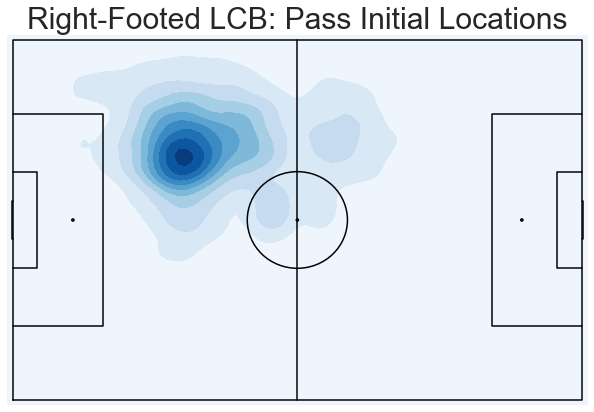

In [103]:
heatmap(a,b, 'Right-Footed LCB: Pass Initial Locations', 'Blues')

In [104]:
a,b = get_xy(rrrl, 'L_CB_acchighpassloc', len(rrrl), 0) #Aerial Pass Initial Location

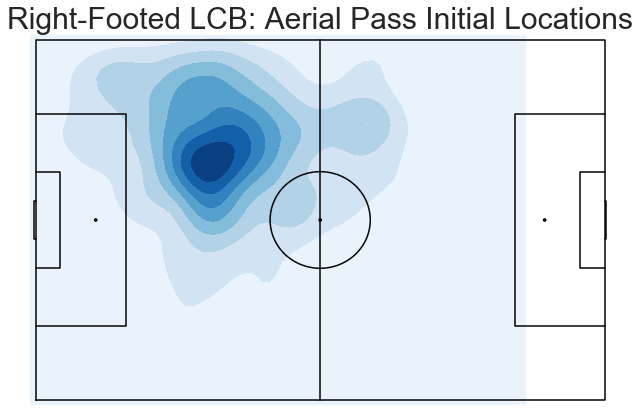

In [105]:
heatmap(a, b, 'Right-Footed LCB: Aerial Pass Initial Locations', 'Blues')

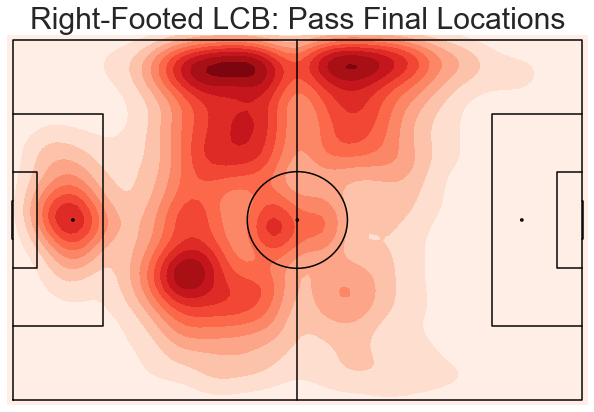

In [106]:
heatmap(x,y, 'Right-Footed LCB: Pass Final Locations', 'Reds')

In [107]:
x,y = get_xy(rrrl, 'L_CB_acchighpassloc', len(rrrl), 1)

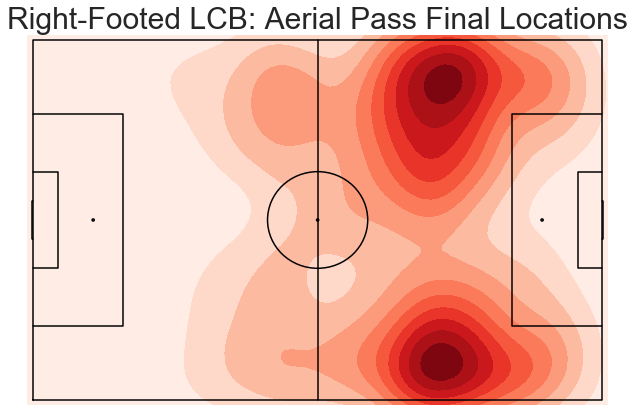

In [108]:
heatmap(x, y, 'Right-Footed LCB: Aerial Pass Final Locations', 'Reds')

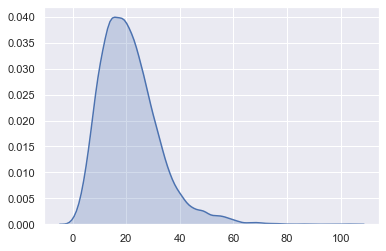

In [109]:
dist = compute_dist_pdf(rrrl, 'L_CB_accpassloc')

In [152]:
# (rrrl['L_CB_accpass'].sum()/rrrl['L_CB_pass'].sum())*100

### Inaccurate Passes

In [111]:
a,b = get_xy(rrrl, 'L_CB_inaccpassloc', len(rrrl), 0)

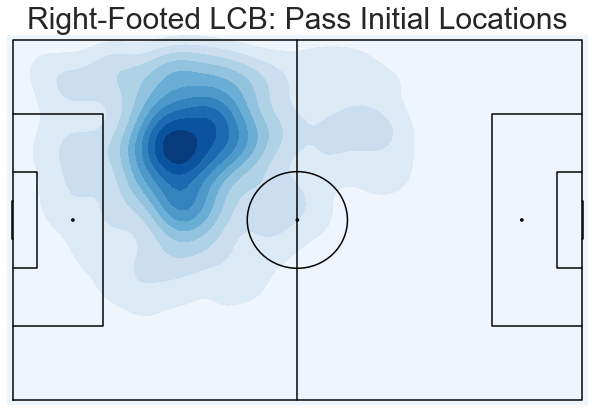

In [112]:
heatmap(a,b, 'Right-Footed LCB: Pass Initial Locations', 'Blues')

In [113]:
x,y = get_xy(rrrl, 'L_CB_inaccpassloc', len(rrrl), 1)

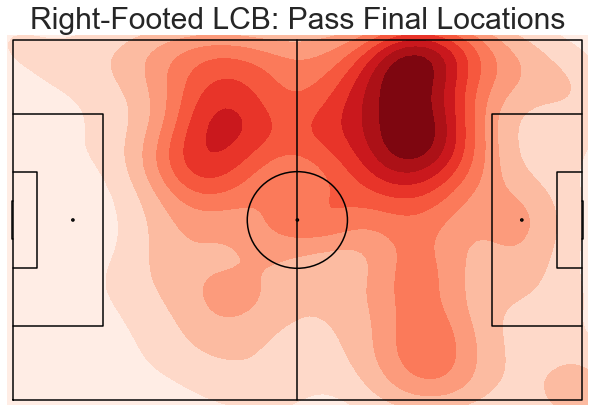

In [114]:
heatmap(x,y, 'Right-Footed LCB: Pass Final Locations', 'Reds')

## 'RRLL' - Left Footed LCB

### Accurate Passes

In [115]:
a,b = get_xy(rrll, 'L_CB_accpassloc', len(rrll), 0)

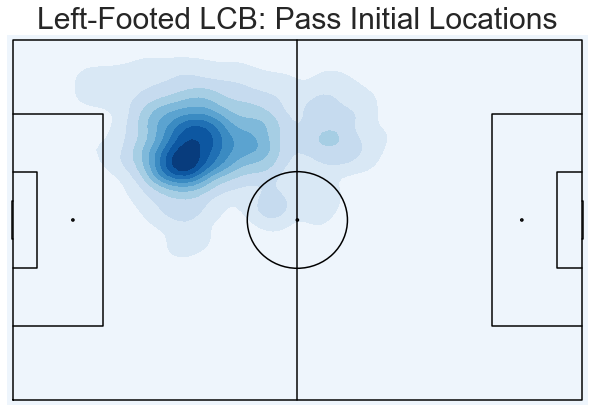

In [116]:
heatmap(a,b, 'Left-Footed LCB: Pass Initial Locations', 'Blues')

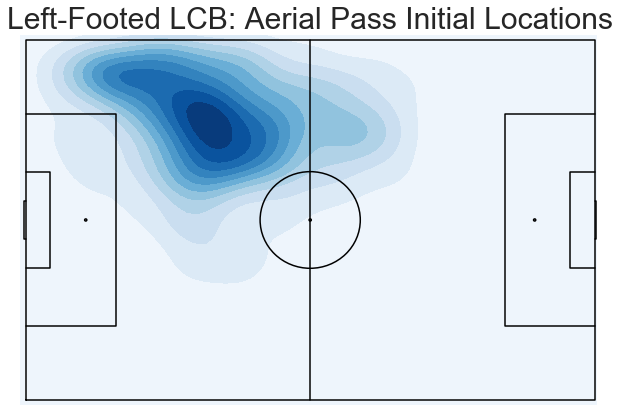

In [117]:
a,b = get_xy(rrll, 'L_CB_acchighpassloc', len(rrll), 0)
heatmap(a, b, 'Left-Footed LCB: Aerial Pass Initial Locations', 'Blues')

In [118]:
x1,y1 = get_xy(rrll, 'L_CB_accpassloc', len(rrll), 1)

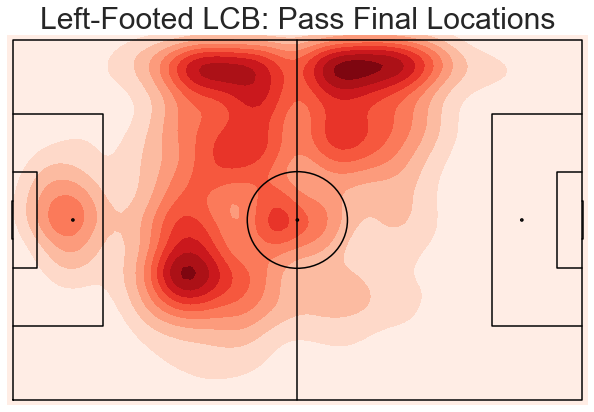

In [119]:
heatmap(x1,y1, 'Left-Footed LCB: Pass Final Locations', 'Reds')

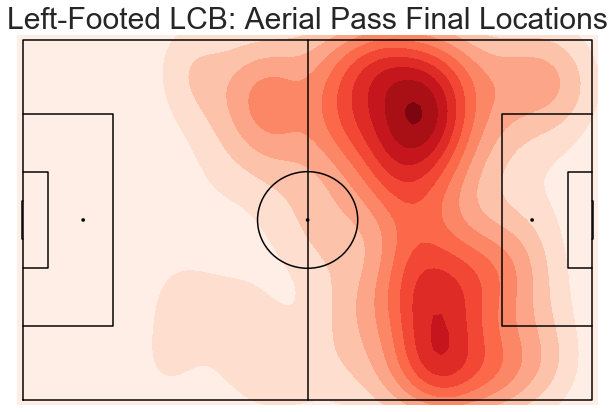

In [120]:
x,y = get_xy(rrll, 'L_CB_acchighpassloc', len(rrll), 1)
heatmap(x, y, 'Left-Footed LCB: Aerial Pass Final Locations', 'Reds')

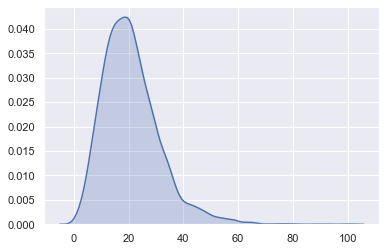

In [121]:
dist1 = compute_dist_pdf(rrll, 'L_CB_accpassloc')

In [154]:
# (rrll['L_CB_accpass'].sum()/rrll['L_CB_pass'].sum())*100

In [153]:
# rrll['L_CB'].value_counts()

### Inaccurate Passes

In [124]:
a,b = get_xy(rrll, 'L_CB_inaccpassloc', len(rrll), 0)

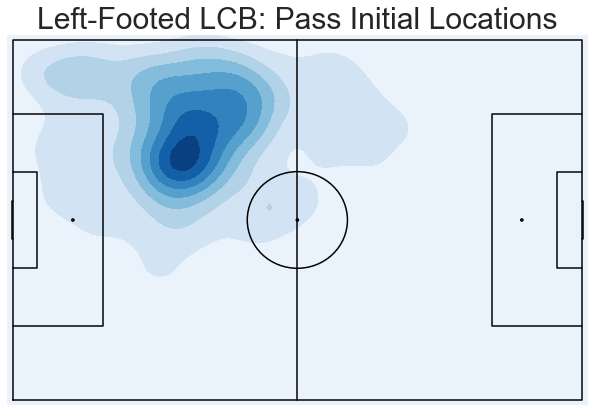

In [125]:
heatmap(a,b, 'Left-Footed LCB: Pass Initial Locations', 'Blues')

In [126]:
x1,y1 = get_xy(rrll, 'L_CB_inaccpassloc', len(rrll), 1)

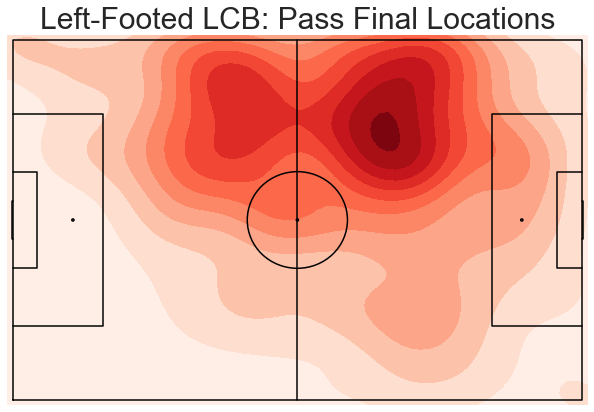

In [127]:
heatmap(x1,y1, 'Left-Footed LCB: Pass Final Locations', 'Reds')

##  3 CB Formations: Left Footed LCB

In [128]:
a,b = get_xy(lcb_lf, 'LCB_accpassloc', len(lcb_lf), 0)
x,y = get_xy(lcb_lf, 'LCB_accpassloc', len(lcb_lf), 1)

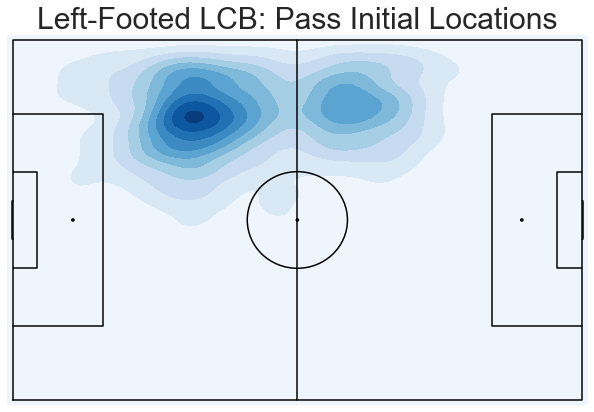

In [129]:
heatmap(a,b, 'Left-Footed LCB: Pass Initial Locations', 'Blues')

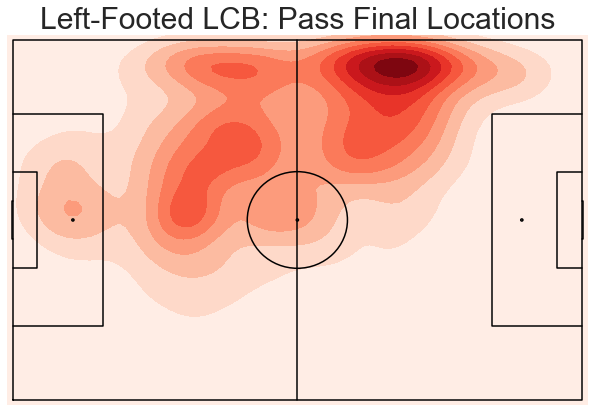

In [130]:
heatmap(x,y, 'Left-Footed LCB: Pass Final Locations', 'Reds')

## 3 CB Formations: Right footed LCB 

In [131]:
a,b = get_xy(lcb_rf, 'LCB_accpassloc', len(lcb_rf), 0)
x,y = get_xy(lcb_rf, 'LCB_accpassloc', len(lcb_rf), 1)

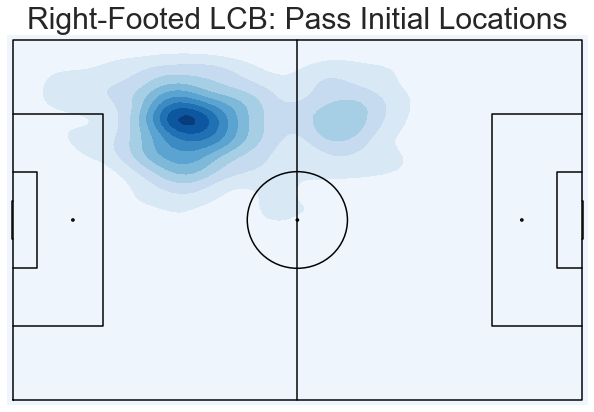

In [132]:
heatmap(a,b, 'Right-Footed LCB: Pass Initial Locations', 'Blues')

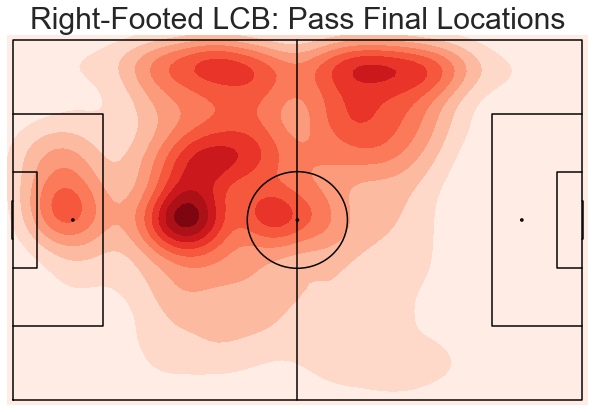

In [133]:
heatmap(x,y, 'Right-Footed LCB: Pass Final Locations', 'Reds')

# Long Distance Pass Analysis 

## RRRL - Right Footed LCB

In [134]:
r_a, r_b = dist_threshold(rrrl, 'L_CB_accpassloc', len(rrrl), 0)
r_x, r_y = dist_threshold(rrrl, 'L_CB_accpassloc', len(rrrl), 1)

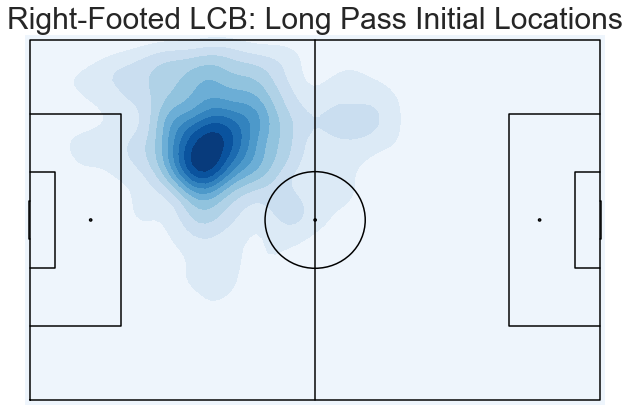

In [135]:
heatmap(r_a, r_b, 'Right-Footed LCB: Long Pass Initial Locations', 'Blues')

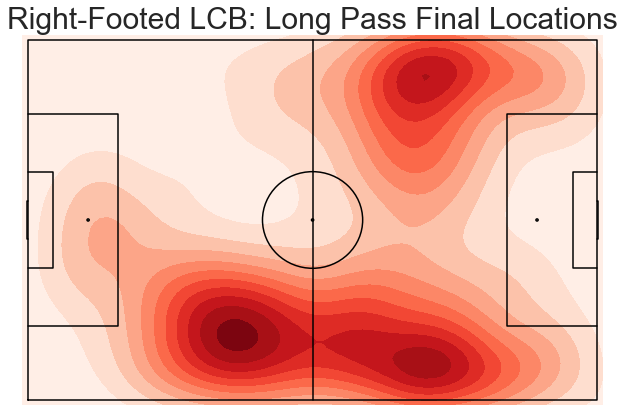

In [136]:
heatmap(r_x, r_y, 'Right-Footed LCB: Long Pass Final Locations', 'Reds')

## RRLL - Left Footed LCB

In [137]:
l_a, l_b = dist_threshold(rrll, 'L_CB_accpassloc', len(rrll), 0)
l_x, l_y = dist_threshold(rrll, 'L_CB_accpassloc', len(rrll), 1)

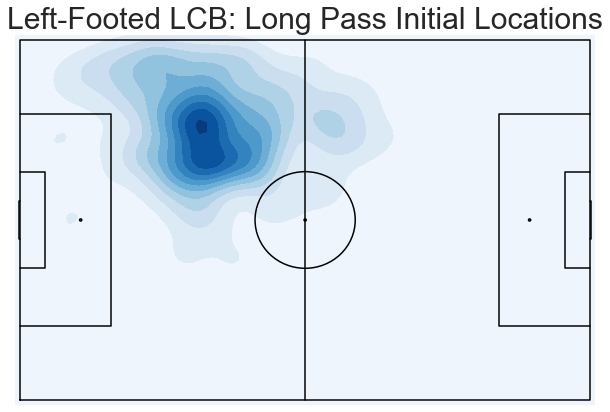

In [138]:
heatmap(l_a, l_b, 'Left-Footed LCB: Long Pass Initial Locations', 'Blues')

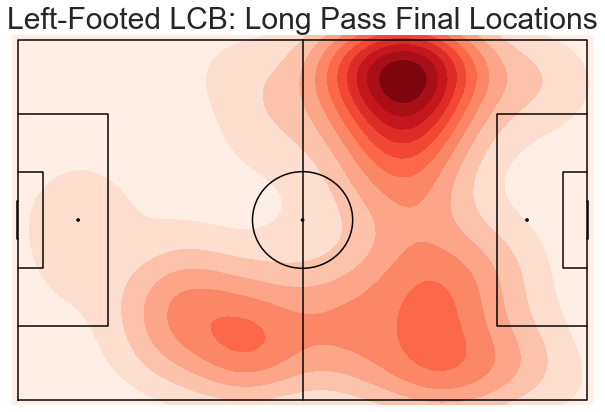

In [139]:
heatmap(l_x, l_y, 'Left-Footed LCB: Long Pass Final Locations', 'Reds')

## 3 CB Formations: Left Footed LCB 

In [140]:
lf_long_i_x,lf_long_i_y = dist_threshold(lcb_lf, 'LCB_accpassloc', len(lcb_lf), 0)
lf_long_f_x,lf_long_f_y = dist_threshold(lcb_lf, 'LCB_accpassloc', len(lcb_lf), 1)

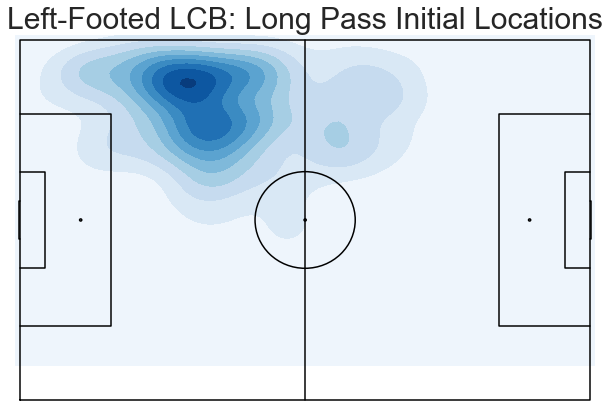

In [141]:
heatmap(lf_long_i_x,lf_long_i_y, 'Left-Footed LCB: Long Pass Initial Locations', 'Blues')

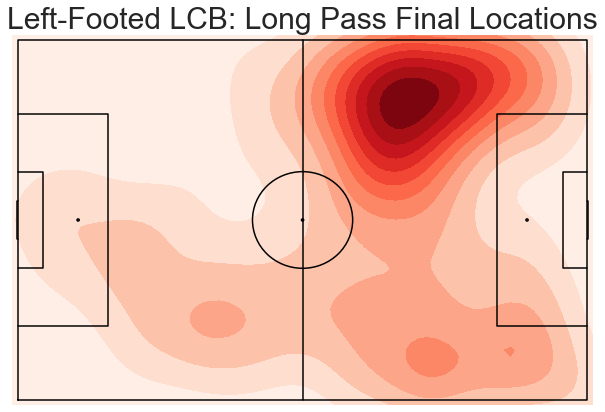

In [142]:
heatmap(lf_long_f_x,lf_long_f_y, 'Left-Footed LCB: Long Pass Final Locations', 'Reds')

##  3 CB Formations: Right Footed LCB

In [143]:
rf_long_i_x,rf_long_i_y = dist_threshold(lcb_rf, 'LCB_accpassloc', len(lcb_rf), 0)
rf_long_f_x,rf_long_f_y = dist_threshold(lcb_rf, 'LCB_accpassloc', len(lcb_rf), 1)

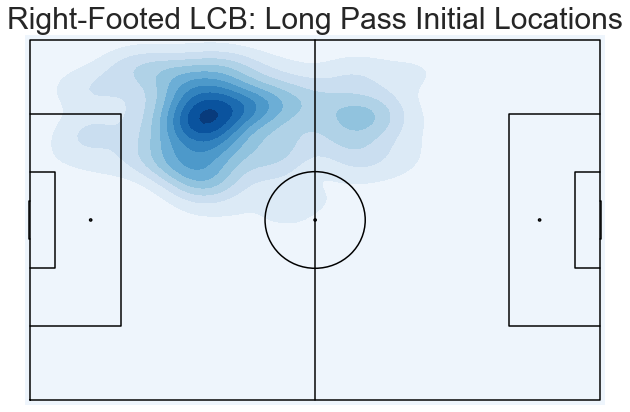

In [144]:
heatmap(rf_long_i_x,rf_long_i_y, 'Right-Footed LCB: Long Pass Initial Locations', 'Blues')

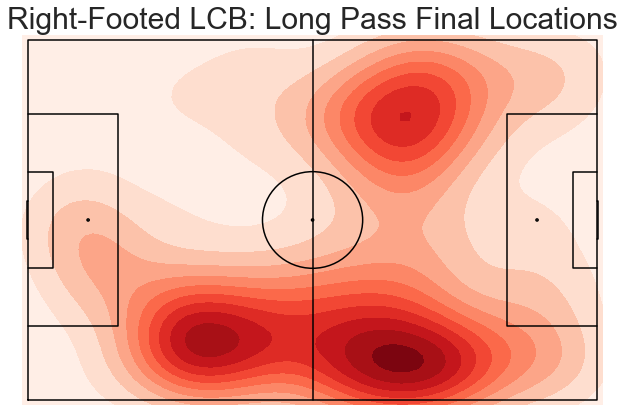

In [145]:
heatmap(rf_long_f_x,rf_long_f_y, 'Right-Footed LCB: Long Pass Final Locations', 'Reds')

# Inferences 

1. A Right footed LCB makes the most accurate passes in:<br>
    i. Left Wing Defence Region <br>
    ii. Left Wing Attack Region<br>
    iii. Right Central Defence <br>
2. Out of all these passes, a Right footed LCB makes the most `Long Passes` in:<br>
    i. Right Wing Attack Region <br>
    ii. Right Wing Defence Region <br>
    iii. Left Wing Attack Region <br>
3.  A Left footed LCB makes the most accurate passes in:<br>
    i. Left Wing Attack Region <br>
    ii. Left Wing Defence Region<br>
    iii. Right Central Defence <br>
4. Out of all these passes, a Left footed LCB makes the most `Long Passes` in:<br>
    i. Left Wing Attack Region <br>
    ii. Right + Left Central Attack Region <br>
    iii. Right Wing Attack Region <br>
**Note**: *The `Long Accurate Passes` of a Right footed LCB are observed to be more on either flanks and much lesser central than a Left footed LCB* <br>

# Region Percentages 

Order:<br>percentage(x_rightflank_attack), percentage(x_rightflank_def), percentage(
        x_leftflank_attack), percentage(x_leftflank_def), percentage(
            x_rightcentral_attack), percentage(x_rightcentral_def), percentage(
                x_leftcentral_attack), percentage(x_leftcentral_def)

## 4 CB Formations 

In [146]:
# #RRRL
# r = get_region(r_x, r_y)
# print(r)
# reg_rrrl = [(i/len(r_x))*100 for i in r]
# print(reg_rrrl)
# print(len(r_x))
rrrl_region= get_region(r_x, r_y)
print(rrrl_region)
print(len(r_x))
regions = ['rightflank_attack','rightflank_def',
           'leftflank_attack','leftflank_def',
           'rightcentral_attack','rightcentral_def',
           'leftcentral_attack','leftcentral_def']
rrrl_region_per = [i/len(r_x)*100 for i in rrrl_region]
for region, percent in zip(regions,rrrl_region_per):
    print(region,":",percent)

[301, 236, 247, 37, 96, 137, 107, 39]
1200
rightflank_attack : 25.083333333333336
rightflank_def : 19.666666666666664
leftflank_attack : 20.583333333333336
leftflank_def : 3.0833333333333335
rightcentral_attack : 8.0
rightcentral_def : 11.416666666666666
leftcentral_attack : 8.916666666666668
leftcentral_def : 3.25


In [147]:
# #RRLL
# r = get_region(l_x, l_y)
# print(r)
# reg_rrll = [(i/len(l_x))*100 for i in r]
# print(reg_rrll)
# print(len(l_x))
rrll_region = get_region(l_x, l_y)
print(rrll_region)
print(len(l_x))
regions = ['rightflank_attack','rightflank_def',
           'leftflank_attack','leftflank_def',
           'rightcentral_attack','rightcentral_def',
           'leftcentral_attack','leftcentral_def']
rrll_region_per = [i/len(l_x)*100 for i in rrll_region]
for region, percent in zip(regions,rrll_region_per):
    print(region,":",percent)

[116, 75, 175, 22, 76, 51, 69, 25]
609
rightflank_attack : 19.047619047619047
rightflank_def : 12.31527093596059
leftflank_attack : 28.735632183908045
leftflank_def : 3.6124794745484397
rightcentral_attack : 12.479474548440066
rightcentral_def : 8.374384236453201
leftcentral_attack : 11.330049261083744
leftcentral_def : 4.105090311986864


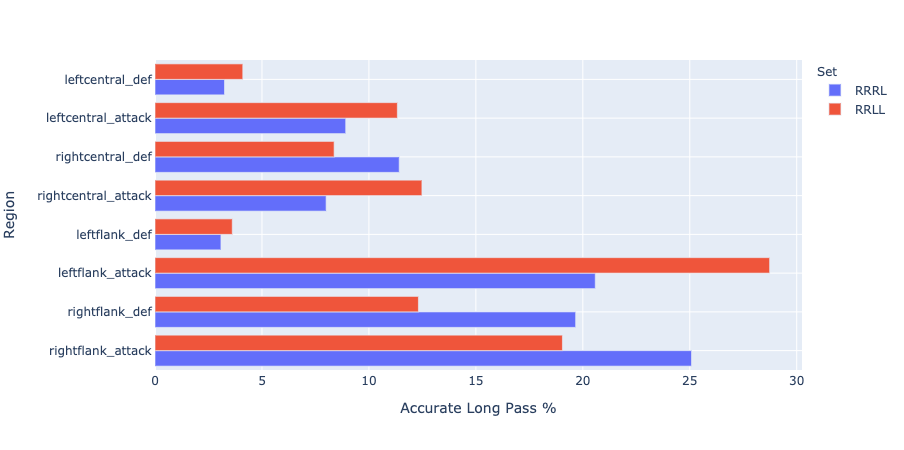

In [148]:
# data_reg = [['Right Flank Attack', 25.517241379310345, 'RRRL'],
#             ['Right Flank Attack',19.224283305227654, 'RRLL'],
#             ['Right Flank Def', 20.086206896551726, 'RRRL'],
#             ['Right Flank Def', 12.478920741989882, 'RRLL'],
#             ['Left Flank Attack', 20.17241379310345, 'RRRL'],
#             ['Left Flank Attack', 28.836424957841484, 'RRLL'],
#             ['Left Flank Def', 3.189655172413793, 'RRRL'],
#             ['Left Flank Def', 3.204047217537943, 'RRLL'],
#             ['Right Central Attack', 7.5, 'RRRL'],
#             ['Right Central Attack', 12.647554806070826, 'RRLL'],
#             ['Right Central Def', 11.637931034482758, 'RRRL'],
#             ['Right Central Def', 8.600337268128163, 'RRLL'],
#             ['Left Central Attack', 8.620689655172415, 'RRRL'],
#             ['Left Central Attack', 10.961214165261383, 'RRLL'],
#             ['Left Central Def', 3.2758620689655173, 'RRRL'],
#             ['Left Central Def', 4.0472175379426645, 'RRLL']]
# reg = pd.DataFrame(data_reg, columns = ['Region', 'Accurate Long Pass %', 'Set'])
# fig = px.bar(reg, x="Accurate Long Pass %", y="Region", color='Set', barmode='group', orientation='h')
# fig.show()
rrrl_data = list(zip(regions,rrrl_region_per))
rrrl_data_reg = [list(i) + ["RRRL"] for i in rrrl_data]
rrll_data = list(zip(regions,rrll_region_per))
rrll_data_reg = [list(i) + ["RRLL"] for i in rrll_data]
data_reg = rrrl_data_reg + rrll_data_reg
reg = pd.DataFrame(data_reg, columns = ['Region', 'Accurate Long Pass %', 'Set'])
fig = px.bar(reg, x="Accurate Long Pass %", y="Region", color='Set', barmode='group', orientation='h')
fig.show()

## 3 CB Formations 

In [149]:
# r_lf = get_region(lf_long_f_x,lf_long_f_y)
# print(r_lf)
# reg_lcb_lf = [(i/len(lf_long_f_x))*100 for i in r_lf]
# reg_lcb_lf
left_foot_region = get_region(lf_long_f_x, lf_long_f_y)
print(left_foot_region)
print(len(lf_long_f_x))
regions = ['rightflank_attack','rightflank_def',
           'leftflank_attack','leftflank_def',
           'rightcentral_attack','rightcentral_def',
           'leftcentral_attack','leftcentral_def']
left_foot_region_per = [i/len(lf_long_f_x)*100 for i in left_foot_region]
for region, percent in zip(regions,left_foot_region_per):
    print(region,":",percent)

[57, 21, 105, 10, 32, 27, 45, 13]
310
rightflank_attack : 18.387096774193548
rightflank_def : 6.774193548387098
leftflank_attack : 33.87096774193548
leftflank_def : 3.225806451612903
rightcentral_attack : 10.32258064516129
rightcentral_def : 8.709677419354838
leftcentral_attack : 14.516129032258066
leftcentral_def : 4.193548387096775


In [150]:
# r_rf = get_region(rf_long_f_x,rf_long_f_y)
# print(r_rf)
# reg_lcb_rf = [(i/len(rf_long_f_x))*100 for i in r_rf]
# reg_lcb_rf
right_foot_region = get_region(rf_long_f_x, rf_long_f_y)
print(right_foot_region)
print(len(rf_long_f_x))
regions = ['rightflank_attack','rightflank_def',
           'leftflank_attack','leftflank_def',
           'rightcentral_attack','rightcentral_def',
           'leftcentral_attack','leftcentral_def']
right_foot_region_per = [i/len(rf_long_f_x)*100 for i in right_foot_region]
for region, percent in zip(regions,right_foot_region_per):
    print(region,":",percent)

[111, 78, 64, 14, 36, 38, 39, 10]
390
rightflank_attack : 28.46153846153846
rightflank_def : 20.0
leftflank_attack : 16.41025641025641
leftflank_def : 3.5897435897435894
rightcentral_attack : 9.230769230769232
rightcentral_def : 9.743589743589745
leftcentral_attack : 10.0
leftcentral_def : 2.564102564102564


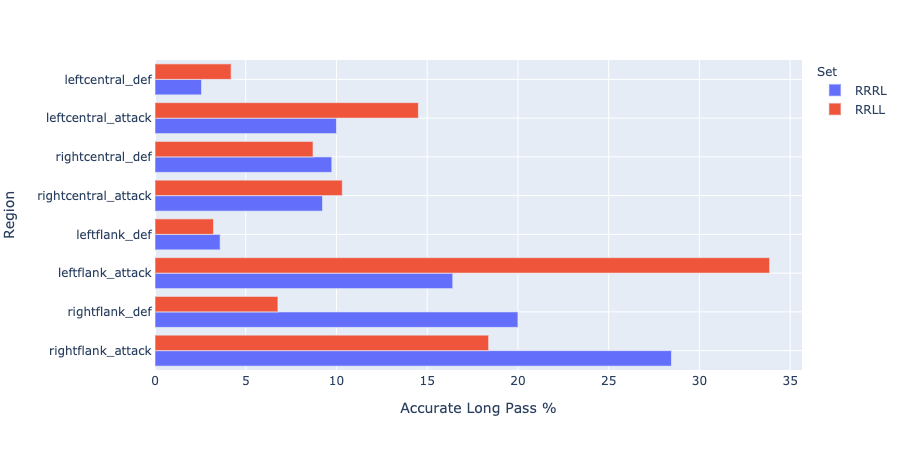

In [151]:
# data_reg = [['Right Flank Attack', 29.100529100529098, 'Right-footed-LCB'],
#             ['Right Flank Attack',18.620689655172416, 'Left-footed-LCB'],
#             ['Right Flank Def', 20.37037037037037, 'Right-footed-LCB'],
#             ['Right Flank Def', 7.241379310344828, 'Left-footed-LCB'],
#             ['Left Flank Attack',16.402116402116402 , 'Right-footed-LCB'],
#             ['Left Flank Attack', 34.82758620689655, 'Left-footed-LCB'],
#             ['Left Flank Def', 3.439153439153439, 'Right-footed-LCB'],
#             ['Left Flank Def', 2.7586206896551726, 'Left-footed-LCB'],
#             ['Right Central Attack', 8.465608465608465, 'Right-footed-LCB'],
#             ['Right Central Attack', 8.96551724137931, 'Left-footed-LCB'],
#             ['Right Central Def',10.052910052910052 , 'Right-footed-LCB'],
#             ['Right Central Def',9.310344827586208, 'Left-footed-LCB'],
#             ['Left Central Attack',9.523809523809524, 'Right-footed-LCB'],
#             ['Left Central Attack', 13.793103448275861, 'Left-footed-LCB'],
#             ['Left Central Def',2.6455026455026456, 'Right-footed-LCB'],
#             ['Left Central Def', 4.482758620689655, 'Left-footed-LCB']]
# reg = pd.DataFrame(data_reg, columns = ['Region', 'Accurate Long Pass %', 'Set'])
# fig = px.bar(reg, x="Accurate Long Pass %", y="Region", color='Set', barmode='group', orientation='h')
# fig.show()
right_foot_data = list(zip(regions,right_foot_region_per))
right_foot_data_reg = [list(i) + ["RRRL"] for i in right_foot_data]
left_foot_data = list(zip(regions,left_foot_region_per))
left_foot_data_reg = [list(i) + ["RRLL"] for i in left_foot_data]
data_reg = right_foot_data_reg + left_foot_data_reg
reg = pd.DataFrame(data_reg, columns = ['Region', 'Accurate Long Pass %', 'Set'])
fig = px.bar(reg, x="Accurate Long Pass %", y="Region", color='Set', barmode='group', orientation='h')
fig.show()

# Test for Statistical Significance (for significance level - 0.05) for four defender formation

## Right - Flank

**Null Hypothesis:** The proportion of passes made at the right flank by left footed LCB (left center back) should be greater than or equal to right footed LCB (left center back) in a lineup with four defenders<br><br>
**Alternate Hypothesis:** The proportion of passes made at the right flank by left footed LCB (left center back) should be less than right footed LCB (left center back) in a lineup with four defenders

**H0: P2 >= P1** <br>
**H1: P2 < P1** <br>
*P1 - RRRL, P2 - RRLL*

**The hypothesis stated signifies that we are performing a right tailed test**

## Test for proportions in Right Flank region

In [155]:
# from statsmodels.stats.proportion import proportions_ztest
# count = np.array([529, 188])
# nobs = np.array([1160, 593])
# stat, pval = proportions_ztest(count, nobs, alternative ='larger')
# print(stat, pval)
from statsmodels.stats.proportion import proportions_ztest
count = np.array([rrrl_region[0]+rrrl_region[1],rrll_region[0]+rrll_region[1]])
nobs = np.array([len(r_x), len(l_x)])
stat, pval = proportions_ztest(count, nobs, alternative ='larger')
print(stat, pval)

5.486897516862808 2.0452714245300046e-08


Since the p-value is less than 0.05, we have statistically significant difference at 0.05 significance.

## Left - Flank

**Null Hypothesis:** The proportion of passes made at the left flank by right footed LCB (left center back) should be greater than or equal to left footed LCB (left center back) in a lineup with four defenders<br><br>
**Alternate Hypothesis:** The proportion of passes made at the left flank by right footed LCB (left center back) should be lesser than left footed LCB (left center back) in a lineup with four defenders

**H0: P1 >= P2** <br>
**H1: P1 < P2** <br>
*P1 - RRRL, P2 - RRLL*

**The hypothesis stated signifies that we are performing a left tailed test**

## Test for proportions in Left Flank region

In [156]:
count = np.array([rrrl_region[2]+rrrl_region[3], rrll_region[2]+rrll_region[3]])
nobs = np.array([len(r_x), len(l_x)])
stat, pval = proportions_ztest(count, nobs,alternative='smaller')
print(stat, pval)

-3.9494715964225455 3.9161951953051096e-05


Since the p-value is less than 0.05, we have statistically significant difference at 0.05 significance.

## Central - Region

**Null Hypothesis:** The proportion of passes made in the central region by right footed LCB (left center back) should be equal to that of left footed LCB (left center back) in a lineup with four defenders<br><br>
**Alternate Hypothesis:** The proportion of passes made in the central region by right footed LCB (left center back) should not be equal to that of left footed LCB (left center back) in a lineup with four defenders

**H0: P1 = P2** <br>
**H1: P1 != P2** <br>
*P1 - RRRL, P2 - RRLL*

## Test for proportions in Central region

In [162]:
count = np.array([rrrl_region[4]+rrrl_region[5]+rrrl_region[6]+rrrl_region[7], rrll_region[4]+rrll_region[5]+rrll_region[6]+rrll_region[7]])
nobs = np.array([len(r_x), len(l_x)])
stat, pval = proportions_ztest(count, nobs)
print(stat, pval)

-2.008865154397588 0.04455143623116148


Since the p-value is less than 0.05, we have statistically significant difference at 0.05 significance.

# Test for Statistical Significance (for significance level - 0.05) for three/five defender formation

## Right - Flank

**Null Hypothesis:** The proportion of passes made at the right flank by left footed LCB (left center back) should be greater than or equal to right footed LCB (left center back) in a lineup with three/five defenders<br><br>
**Alternate Hypothesis:** The proportion of passes made at the right flank by left footed LCB (left center back) should be less than right footed LCB (left center back) in a lineup with three/five defenders

**H0: P2 >= P1** <br>
**H1: P2 < P1** <br>
*P1 - Right-Footed LCB, P2 - Left-Footed LCB*

**The hypothesis stated signifies that we are performing a right tailed test**

## Test for proportions in Right Flank region

In [159]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([right_foot_region[0]+right_foot_region[1],left_foot_region[0]+left_foot_region[1]])
nobs = np.array([len(rf_long_f_x), len(lf_long_f_x)])
stat, pval = proportions_ztest(count, nobs, alternative ='larger')
print(stat, pval)

6.304100639963163 1.4493605263078683e-10


Since the p-value is less than 0.05, we have statistically significant difference at 0.05 significance.

## Left - Flank

**Null Hypothesis:** The proportion of passes made at the left flank by right footed LCB (left center back) should be greater than or equal to left footed LCB (left center back) in a lineup with three/five defenders<br><br>
**Alternate Hypothesis:** The proportion of passes made at the left flank by right footed LCB (left center back) should be lesser than left footed LCB (left center back) in a lineup with three/five defenders

**H0: P1 >= P2** <br>
**H1: P1 < P2** <br>
*P1 - Right Footed LCB, P2 - Left Footed LCB*

**The hypothesis stated signifies that we are performing a left tailed test**

## Test for proportions in Left Flank region

In [160]:
count = np.array([right_foot_region[2]+right_foot_region[3], left_foot_region[2]+left_foot_region[3]])
nobs = np.array([len(rf_long_f_x), len(lf_long_f_x)])
stat, pval = proportions_ztest(count, nobs,alternative='smaller')
print(stat, pval)

-5.027981974250267 2.4783422824384565e-07


Since the p-value is less than 0.05, we have statistically significant difference at 0.05 significance.

## Central - Region

**Null Hypothesis:** The proportion of passes made in the central region by right footed LCB (left center back) should be equal to that of left footed LCB (left center back) in a lineup with three/five defenders<br><br>
**Alternate Hypothesis:** The proportion of passes made in the central region by right footed LCB (left center back) should not be equal to that of left footed LCB (left center back) in a lineup with three/five defenders

**H0: P1 = P2** <br>
**H1: P1 != P2** <br>
*P1 - Right Footed LCB, P2 - Left Footed LCB*

## Test for proportions in Central Region

In [161]:
count = np.array([right_foot_region[4]+right_foot_region[5]+right_foot_region[6]+right_foot_region[7], left_foot_region[4]+left_foot_region[5]+left_foot_region[6]+left_foot_region[7]])
nobs = np.array([len(rf_long_f_x), len(lf_long_f_x)])
stat, pval = proportions_ztest(count, nobs)
print(stat, pval)

-1.7175626851153591 0.0858764114680888


Since the p-value is greater than 0.05, we do not have a statistically significant difference at 0.05 significance.

# Random Sampling Test
The dataset is sampled at 20% of the total number of entries (i.e. 64 samples for RRRL dataset and 32 samples for RRLL dataset) and the process of computing the accurate long pass percentage across different regions is implemented. These steps are repeated for 50 times and the number of instances where percentage of accurate long passes at right wing and right back region by right footed LCB defender surpasses that of a left footed defender at the same position are noted.

In [71]:
def sample_test(df1, df2, col, n, m):
    # df1 - Right footed LCB
    # df1 - Left footed LCB
    # n - sampling fraction
    # m - no of testing iterations
    c=0
    for i in tqdm(range(m)):
        sample_df1 = df1.sample(frac = n)
        sample_df2 = df2.sample(frac = n)
        sample_df1 = sample_df1.reset_index()
        sample_df2 = sample_df2.reset_index()
        x, y = dist_threshold(sample_df1, col, len(sample_df1), 1)
        x1, y1 = dist_threshold(sample_df2, col, len(sample_df2), 1)
        r = get_region(x, y)
        r1 = get_region(x1, y1)
        if(((r[0]+r[1])/len(x)) > ((r1[0]+r1[0])/len(x1))):
            c=c+1
    print((c/m)*100)

In [72]:
sample_test(rrrl, rrll, 'L_CB_accpassloc', 0.2, 50)

100%|██████████| 50/50 [00:21<00:00,  2.29it/s]

86.0


# Rough 

In [79]:
df_kde = pd.DataFrame(columns=['x', 'y'])
df_kde['x'] = a
df_kde['y'] = b
df_kde

,x,y
0,62.40,56.44
1,27.04,54.40
2,29.12,40.80
3,46.80,57.80
4,60.32,55.08
...,...,...
3963,38.48,57.12
3964,33.28,61.20
3965,26.00,32.64
3966,13.52,44.88


In [80]:
df_kde.values.T

array([[62.4 , 27.04, 29.12, ..., 26.  , 13.52, 28.08],
       [56.44, 54.4 , 40.8 , ..., 32.64, 44.88, 63.92]])

In [81]:
kde = sps.gaussian_kde(df_kde.values.T)

In [82]:
xx, yy = np.meshgrid(
    np.linspace(0, 104, 500),
    np.linspace(0, 68, 500))

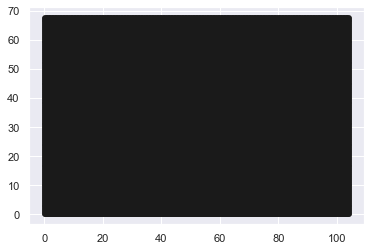

In [83]:
plt.plot(xx, yy, marker='.', color='k', linestyle='none')
plt.show()

In [84]:
xx.ravel()

array([  0.        ,   0.20841683,   0.41683367, ..., 103.58316633,
       103.79158317, 104.        ])

In [85]:
z = kde.pdf([xx.ravel(), yy.ravel()]).reshape(xx.shape)

In [86]:
zi = z > np.max(z) * 0.3

In [87]:
# print some summaries
print('x = (%.1f, %.1f)' % (min(xx[zi]), max(xx[zi])))
print('y = (%.1f, %.1f)' % (min(yy[zi]), max(yy[zi])))
print('area = %.1f' % (130 * 70 * np.mean(zi)))

x = (19.8, 66.1)
y = (40.1, 62.4)
area = 799.7


In [88]:
x1, y1 = est_dense_reg(a, b, 3)
print(x1, y1)

[19.79959919839679, 66.06813627254509] [40.06412825651302, 62.412825651302605]
